### Initialization

In [8]:
# import
import Untitled as da
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

[-3. -1.  0.  0.  0.  5.]


In [3]:
# constants


In [34]:
# measured data
data, notes, conditions = da.import_data()

Δmono = 0.5 # nm
ΔU = 1 # mV
U_0 = 2 # mV
Δa = 1 # °

a_1 = data[0][0] # °
U_1 = data[0][1] # mV
λ_1 = 600 # nm

λ_2 = [768, 905, 1060] # nm
mono_2 = [data[1][0], data[2][0], data[3][0]] # nm
U_2 = [data[1][1], data[2][1], data[3][1]] # mV

mono_la = data[6][0] # nm
U_la = [data[6][1], data[6][2], data[6][3]] # mV

mono_si = [data[7][0], data[8][0]] # nm
U_si = [data[7][1], data[8][1]] # mV

mono_ga = [data[4][0], data[5][0]] # nm
U_ga = [data[4][1], data[5][1]] # mV

From Data the following files were imported:

varname               filename             shape      conditions                       notes                       

data[0]   :           v44_1.txt           2 x 19          0      ['lambda = 600 nm'];  ['delta = 1°', 'delta = 1mV'
data[1]   :           v44_2a.txt          2 x 31          0      ['lambda = 768 nm'];  ['delta = 0.5nm', 'delta = 1
data[2]   :           v44_2b.txt          2 x 31          0      ['lambda = 905 nm'];  ['delta = 0.5nm', 'delta = 1
data[3]   :           v44_2c.txt          2 x 36          0      ['lambda = 1060 nm'];  ['delta = 0.5nm', 'delta = 
data[4]   :           v44_gaas.txt        2 x 52          0      ['delta = 0.5nm' 'delta = 1mV'];  ['mono [nm]' 'Ga
data[5]   :           v44_gaas_cooled.txt 2 x 61          0      ['delta = 0.5nm' 'delta = 1mV'];  ['mono [nm]' 'Ga
data[6]   :           v44_lamp.txt        4 x 41          0      ['delta = 0.5nm' 'delta = 1mV' 'delta = 1mV' 'delt
data[7]   :           v44

In [10]:
# theoretical functions
def lin(x, a, b):
    return a*x + b

def gauss(x, a, μ, σ):
    return a/np.sqrt(2*np.pi*σ**2)*np.exp( -(x - μ)**2/(2*σ**2))

def dgauss_dx(x, a, μ, σ):
    return -(x - μ)/(2*σ**2)*gauss(x, a, μ, σ)

### Linearity of the photo diode

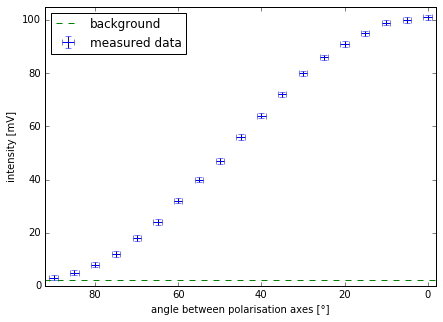

In [11]:
fig,ax = plt.subplots(figsize=(7,5))

ax.errorbar(a_1, U_1, xerr=Δa, yerr=ΔU, fmt='none', label='measured data')
ax.axhline(2, ls='--', c='g', label='background')
ax.set_xlim(-2, 92)
ax.set_ylim(0, 105)
ax.invert_xaxis()
ax.legend(loc=0)
ax.set_xlabel('angle between polarisation axes [°]')
ax.set_ylabel('intensity [mV]')
#fig.savefig('angle_plot.pdf')

In [12]:
opt_1, cov_1 = curve_fit(lin, np.sin(a_1*np.pi/180)**2, U_1 - U_0)

sin2 = np.sin((a_1 - 90)*np.pi/180)**2
Δsin2 = 2*np.sin((a_1 - 90)*np.pi/180)*np.cos((a_1 - 90)*np.pi/180)*np.pi/180*Δa
sigma_1 = np.sqrt(ΔU**2 + (opt_1[0]*Δsin2)**2)

opt_1, cov_1 = curve_fit(lin, sin2, U_1 - U_0, sigma = sigma_1, absolute_sigma = True)
err_1 = np.sqrt(np.diag(cov_1))
χ2_1 = sum((U_1 - U_0 - lin(sin2, *opt_1))**2/sigma_1**2)/(len(U_1) - len(opt_1))

opt_1, err_1, χ2_1

(array([ 96.76710603,   3.30739087]),
 array([ 0.75149073,  0.48922428]),
 1.2583523034757724)

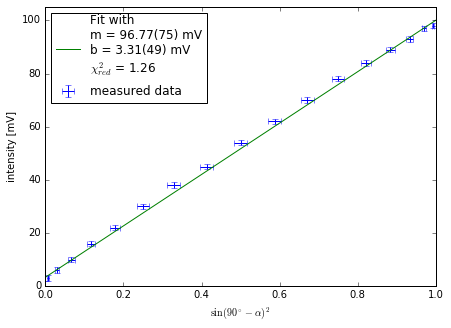

In [13]:
fig,ax = plt.subplots(figsize=(7,5))

ax.errorbar(sin2, U_1 - U_0, xerr=Δsin2, yerr=ΔU, fmt='none', label='measured data')
x = np.linspace(0, 1, 100)
ax.plot(x, lin(x, *opt_1), label="""Fit with
m = %.2f(%.f) mV
b = %.2f(%.f) mV
$\chi^2_{red}$ = %.2f"""%(opt_1[0], 10**2*err_1[0], opt_1[1], 10**2*err_1[1], χ2_1))
ax.set_ylim(0, 105)
#ax.invert_xaxis()
ax.legend(loc=0)
ax.set_xlabel(r'$\sin(90^\circ-\alpha)^2$')
ax.set_ylabel('intensity [mV]')
#fig.savefig('angle_fit.pdf')

In [106]:
opt_2 = np.zeros([3,3])
cov_2 = np.zeros([3,3,3])
err_2 = np.zeros([3,3])
χ2_2 = np.zeros(3)

for i in [0,1,2]:
    opt_2[i], cov_2[i] = curve_fit(gauss, mono_2[i], U_2[i] - U_0, p0 = [200, λ_2[i], 30])
    sigma_2 = np.sqrt(ΔU**2 + (Δmono*dgauss_dx(mono_2[i], *opt_2[i]))**2)
    print(sigma_2)
    opt_2[i], cov_2[i] = curve_fit(gauss, mono_2[i], U_2[i] - U_0, sigma = sigma_2, p0 = [200, λ_2[i], 30],
                                   absolute_sigma = True)
    err_2[i] = np.sqrt(np.diag(cov_2[i]))
    χ2_2[i] = sum((U_2[i] - U_0 - gauss(mono_2[i], *opt_2[i]))**2/sigma_2**2)/(len(U_2[i]) - len(opt_2[i]))

opt_2, err_2, χ2_2

[  3.64469774   4.97149906   6.53980223   8.23745882   9.88679874
  11.25428394  12.07876766  12.116462    11.19477649   9.26264859
   6.42571842   2.98675585   1.43268168   4.85766396   8.03155936
  10.41172223  11.81000693  12.20723987  11.72454516  10.57912129
   9.03036106   7.32940473   5.68244275   4.23246216   3.05839466
   2.18617064   1.60287685   1.2644751    1.10016511   1.03347663
   1.01010502]
[ 5.46669883  6.52590127  7.51587664  8.3219641   8.82243991  8.90473312
  8.48404863  7.52127517  6.03725571  4.12458674  2.00043661  1.20739934
  3.19153122  5.23858253  6.92778547  8.12680954  8.78486396  8.91612056
  8.58728488  7.90101647  6.97721047  5.9353795   4.88082937  3.89613276
  3.03806325  2.33891976  1.81008517  1.44496758  1.22003855  1.09829398
  1.04016508]
[ 1.00102427  1.00230275  1.00493661  1.01008106  1.01958154  1.03610883
  1.06306563  1.10406997  1.16193169  1.23733007  1.32768605  1.42670883
  1.52477238  1.6099676   1.66959613  1.69194002  1.66821316  1.

(array([[  5.60961063e+03,   7.64849639e+02,  -5.44416162e+00],
        [  5.47213145e+03,   9.00777735e+02,  -6.33756092e+00],
        [  1.05397062e+03,   1.07183738e+03,   6.91998133e+00]]),
 array([[  3.27610449e+01,   4.99920412e-02,   3.08143966e-02],
        [  3.19688422e+01,   5.44660324e-02,   3.68388235e-02],
        [  8.92899441e+00,   7.00618056e-02,   6.41119997e-02]]),
 array([ 6.00477721,  4.89535785,  3.89212642]))

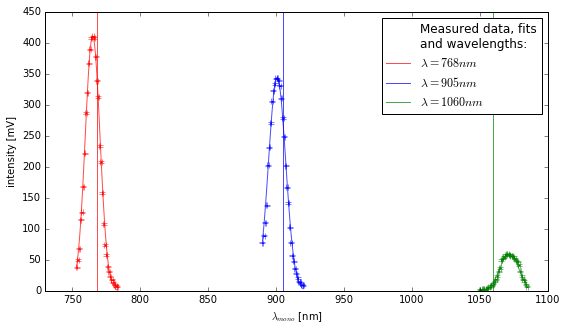

In [78]:
fig,ax = plt.subplots(figsize=(9,5))

ecolors = ['r', 'b', 'g']
colors = ['orange', 'c', 'lightgreen']
ax.plot(0,0,alpha=0, label='Measured data, fits\nand wavelengths:')
#ax.errorbar(0,0,alpha=0, label='measured data:')
for i in [0,1,2]:
    ax.errorbar(mono_2[i], U_2[i] - U_0, xerr=Δmono, yerr=ΔU, ecolor=ecolors[i],
                fmt='none')#, label='$\lambda = %d nm$'%λ_2[i])
    x = np.linspace(min(mono_2[i]), max(mono_2[i]), 100)
    ax.plot(x, gauss(x, *opt_2[i]), c=ecolors[i], label='$\lambda = %d nm$'%λ_2[i], alpha=0.7)
    ax.axvline(λ_2[i], color=ecolors[i], alpha=0.7)#, label='$\lambda = %d nm$'%λ_2[i])

ax.set_xlim(730, 1100)
ax.legend(loc=0)
ax.set_xlabel('$\lambda_{mono}$ [nm]')
ax.set_ylabel('intensity [mV]')
#fig.savefig('mono_fits.pdf')

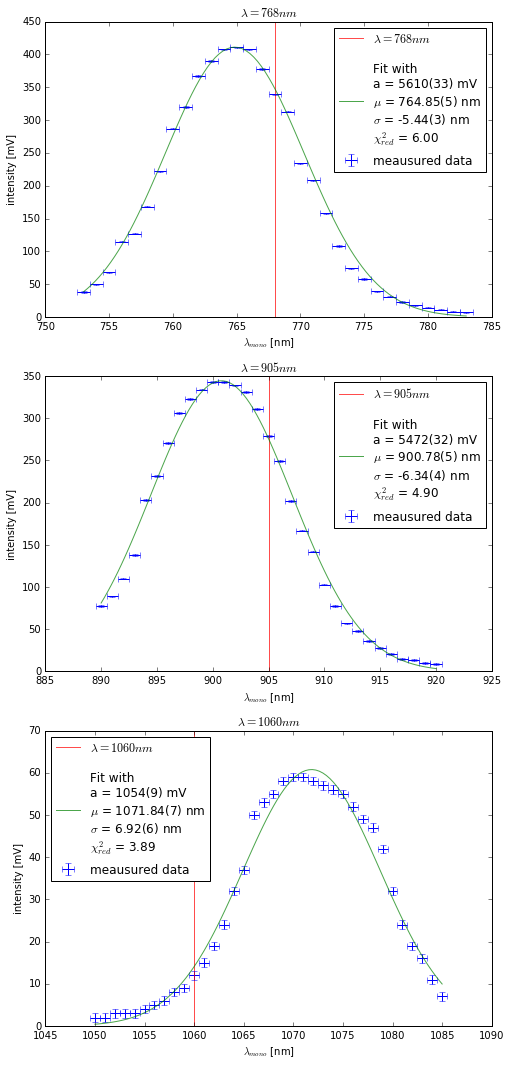

In [95]:
fig,ax = plt.subplots(3,1,figsize=(8,18))

for i in [0,1,2]:
    ax[i].axvline(λ_2[i], color='r', alpha=0.7, label='$\lambda = %d nm$'%λ_2[i])
    ax[i].errorbar(mono_2[i], U_2[i] - U_0, xerr=Δmono, yerr=ΔU, ecolor='b',
                fmt='none', label='meausured data')
    x = np.linspace(min(mono_2[i]), max(mono_2[i]), 100)
    ax[i].plot(x, gauss(x, *opt_2[i]), c='g', alpha=0.7, label="""
Fit with
a = %.f(%.f) mV
$\mu$ = %.2f(%.f) nm
$\sigma$ = %.2f(%.f) nm
$\chi^2_{red}$ = %.2f"""%(opt_2[i][0],
                          10**0*err_2[i][0], opt_2[i][1], 10**2*err_2[i][1], opt_2[i][2], 10**2*err_2[i][2], χ2_2[i]))
    ax[i].set_title('$\lambda = %d nm$'%λ_2[i])
    ax[i].legend(loc=0)
    ax[i].set_xlabel('$\lambda_{mono}$ [nm]')
    ax[i].set_ylabel('intensity [mV]')
#fig.savefig('mono_single_fits.pdf')

In [101]:
λ_mono = np.rollaxis(opt_2,1)[1]
Δλ_mono = np.rollaxis(err_2,1)[1]

opt_3, cov_3 = curve_fit(lin, λ_2, λ_mono, sigma = Δλ_mono, absolute_sigma = True)
err_3 = np.sqrt(np.diag(cov_3))
χ2_3 = sum((λ_mono - lin(λ_2, *opt_3))**2/Δλ_mono**2)/(len(λ_mono) - len(opt_3))

opt_3, err_3, χ2_3

C:\Users\Niklas\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(array([  1.0456246 , -40.45276444]),
 array([ 0.00029074,  0.25800409]),
 1556276.4995859112)

Um das chi2 muss man sich noch kümmern, die Werte verwende ich schon mal weiter, die werden ungefähr passen.

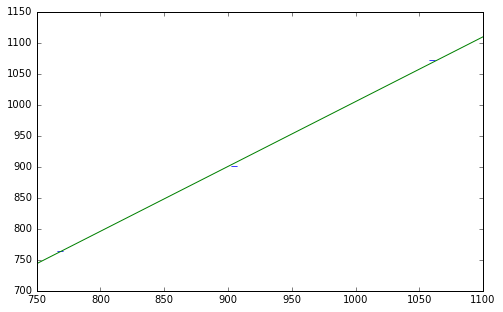

In [102]:
# plots
fig,ax = plt.subplots(figsize=(8,5))

ax.errorbar(λ_2, λ_mono, yerr = Δλ_mono, fmt='none')
x = np.linspace(750,1100,100)
ax.plot(x, lin(x, *opt_3))

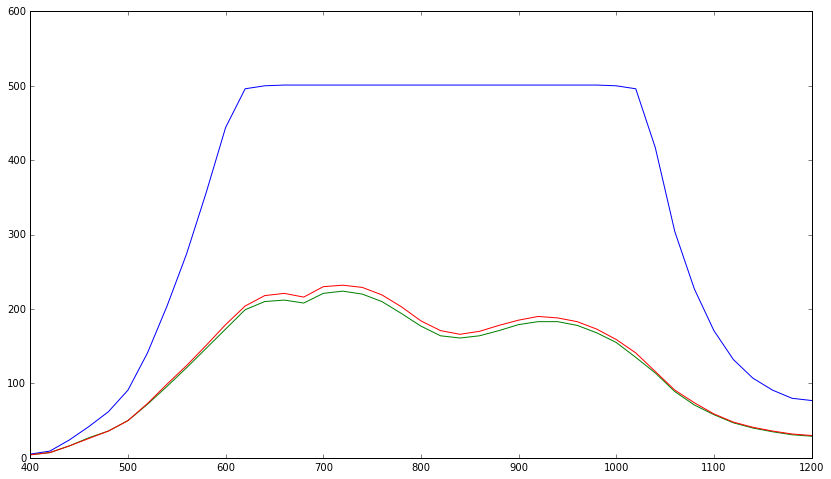

In [8]:
# plots
fig,ax = plt.subplots(figsize=(14,8))

ax.plot(data[6][0],data[6][1],data[6][0],data[6][2],data[6][0],data[6][3])

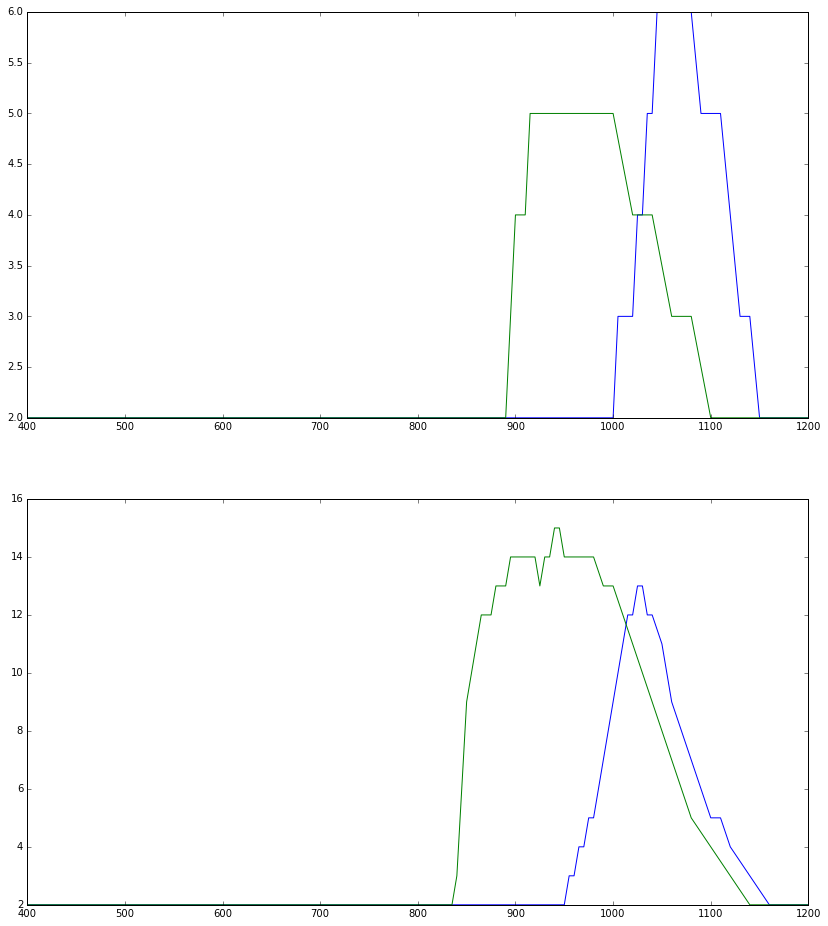

In [12]:
# plots
fig,ax = plt.subplots(2,1,figsize=(14,16))

ax[0].plot(data[7][0],data[7][1],data[4][0],data[4][1])
ax[1].plot(data[8][0],data[8][1],data[5][0],data[5][1])